In [10]:
import pandas as pd
from PIL import Image
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv('../Dataset/faces/train.csv')
PATH = '../Dataset/faces/train/Train'
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [12]:
df.Class.value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

In [13]:
# Define the base path to the directory containing the images
# The 'train.csv' is in 'Dataset/faces/Train/', so the images are in the same directory.
# Based on the file structure (Notebooks -> Age_Detection -> Dataset/faces/Train/)
IMAGE_DIR = '../Dataset/faces/Train/'

Scanning directory: ../Dataset/faces/Train/
Found 19906 JPG/JPEG files. Skipped 0 unreadable files.


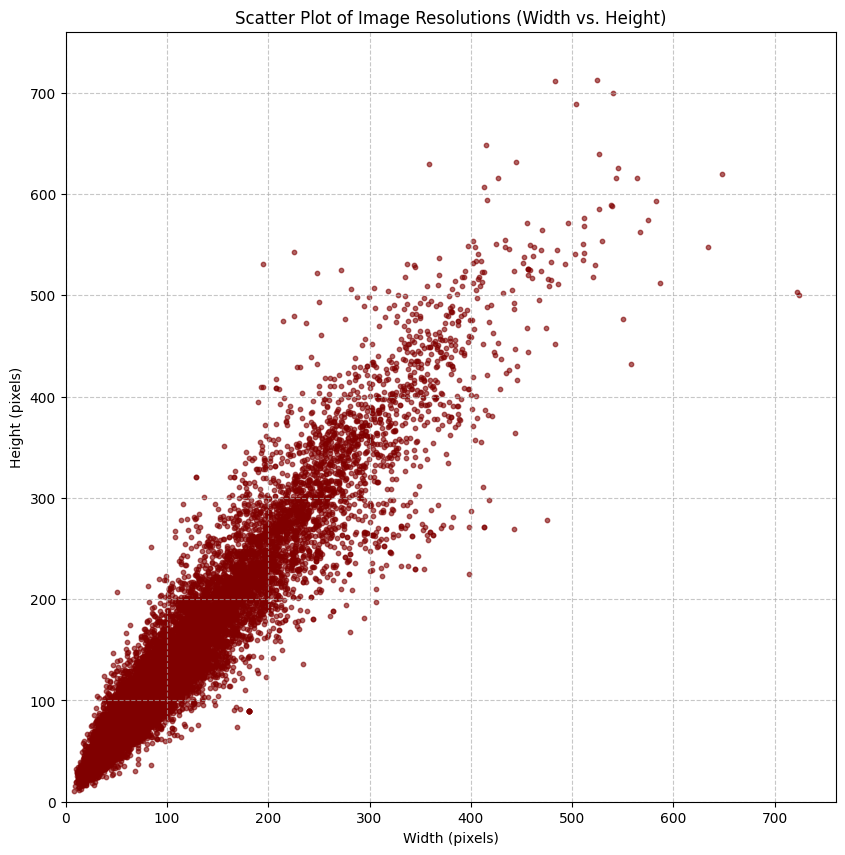

In [14]:


# Define the directory where the images are located
IMAGE_DIR = '../Dataset/faces/Train/'

dimensions = []
error_count = 0
total_files_found = 0

print(f"Scanning directory: {IMAGE_DIR}")
print("Collecting dimensions (Width x Height) for scatter plot...")

# --- 1. Collect Dimensions ---
try:
    for filename in os.listdir(IMAGE_DIR):
        # Only process files with common JPEG extensions
        if filename.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(IMAGE_DIR, filename)
            total_files_found += 1

            try:
                # Open the image and get its size
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append({'Width': width, 'Height': height})
            except Exception:
                error_count += 1
                # Skip unreadable files

except FileNotFoundError:
    print(f"\nERROR: Directory not found at {IMAGE_DIR}. Please check the path.")
    exit() # Exit script gracefully if directory is not found

print(f"Found {total_files_found} JPG/JPEG files. Skipped {error_count} unreadable files.")

dim_df = pd.DataFrame(dimensions)

if dim_df.empty:
    print("No dimensions could be determined for plotting.")
else:
    # --- 2. Generate Scatter Plot ---

    # Calculate limits for a square plot area based on max dimension found
    max_dim = max(dim_df['Width'].max(), dim_df['Height'].max())

    plt.figure(figsize=(10, 10))

    plt.scatter(
        dim_df['Width'],
        dim_df['Height'],
        s=10,
        alpha=0.6,
        color='maroon'
    )

    # Set plot limits to start at 0 and go up to the max dimension found, ensuring a square aspect
    plt.xlim(0, max_dim * 1.05)
    plt.ylim(0, max_dim * 1.05)

    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Scatter Plot of Image Resolutions (Width vs. Height)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box') # Ensure the plot area is square

    plt.show() # Display the plot in your notebook

In [15]:


# --- 2. Filter DataFrame ---

# Create an index list of rows to KEEP (initialized to all rows)
# We will set a value to False for any row corresponding to a small image
keep_rows = pd.Series(True, index=df.index)

MIN_DIMENSION = 50
small_image_count = 0

print(f"Starting with {len(df)} rows. Filtering for images smaller than {MIN_DIMENSION}x{MIN_DIMENSION}...")

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(IMAGE_DIR, image_id)

    try:
        # Open the image using the full path
        with Image.open(image_path) as img:
            width, height = img.size

            # Check if either dimension is smaller than the minimum
            if width < MIN_DIMENSION or height < MIN_DIMENSION:
                # Mark this row for deletion (by setting the keep flag to False)
                keep_rows.loc[index] = False
                small_image_count += 1

    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Skipping this entry.")
        # If the file isn't found, we should probably delete the row,
        # as the data is incomplete. Uncomment the line below to delete:
        # keep_rows.loc[index] = False

    except Exception as e:
        print(f"Error processing image {image_id}: {e}. Skipping this entry.")
        # If the file is corrupted and can't be opened, delete the row.
        keep_rows.loc[index] = False

# Apply the filter to the DataFrame
df_filtered = df[keep_rows]

# --- 3. Results ---

print("---")
print(f"Total small images found and removed: {small_image_count}")
print(f"Original DataFrame size: {len(df)}")
print(f"New DataFrame size: {len(df_filtered)}")
print("\nFirst 5 rows of the filtered DataFrame:")
print(df_filtered.head())

# Update the original df reference if you want to continue working with the filtered data
df = df_filtered

Starting with 19906 rows. Filtering for images smaller than 50x50...
---
Total small images found and removed: 6259
Original DataFrame size: 19906
New DataFrame size: 13647

First 5 rows of the filtered DataFrame:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


In [16]:

keep_rows_format = pd.Series(True, index=df.index)

removed_format_count = 0

print(f"\nStarting format check on {len(df)} images...")

# --- 2. Iterate and Check Format ---

for index, row in df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(IMAGE_DIR, image_id)

    # Check if the file extension is .jpg or .jpeg (case-insensitive)
    if not image_id.lower().endswith(('.jpg', '.jpeg')):
        # Mark this row for deletion
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Removed non-JPG image: {image_id}")
        continue # Skip image processing below

    try:
        # Check the actual file format using PIL
        with Image.open(image_path) as img:
            # Check the image format as reported by PIL
            if img.format not in ('JPEG', 'JPG'):
                keep_rows_format.loc[index] = False
                removed_format_count += 1
                print(f"Removed file with wrong internal format: {image_id} (Internal format: {img.format})")

    except FileNotFoundError:
        # Handle cases where the file might have been moved/deleted after the last check
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Warning: Image file not found during format check: {image_id}. Deleting row.")

    except Exception as e:
        # Handle other errors (e.g., corrupted file)
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Error checking format for image {image_id}: {e}. Deleting row.")


# Update the main df
df = df[keep_rows_format]

print("---")
print(f"Total non-JPG images found and removed: {removed_format_count}")
print(f"New DataFrame size after format check: {len(df)}")


Starting format check on 13647 images...
---
Total non-JPG images found and removed: 0
New DataFrame size after format check: 13647


In [17]:
ALLOWED_CLASSES = ['MIDDLE', 'OLD', 'YOUNG']

print(f"Starting class validation on {len(df)} rows...")

is_allowed = df['Class'].isin(ALLOWED_CLASSES)
df_class_filtered = df[is_allowed]

removed_class_count = len(df) - len(df_class_filtered)

# Update the main df reference
df = df_class_filtered

print("---")
print(f"Original DataFrame size: {len(df) + removed_class_count}")
print(f"Rows with invalid 'Class' removed: {removed_class_count}")
print(f"New DataFrame size: {len(df)}")
print("\nNew value counts for 'Class' column:")
print(df['Class'].value_counts())

Starting class validation on 13647 rows...
---
Original DataFrame size: 13647
Rows with invalid 'Class' removed: 0
New DataFrame size: 13647

New value counts for 'Class' column:
Class
MIDDLE    7009
YOUNG     5056
OLD       1582
Name: count, dtype: int64


In [18]:
OUTPUT_BASE_DIR = '../Dataset_Splita/'
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# We use 'stratify=df["Class"]' to ensure the class distribution is maintained in the split.
df_train_val, df_test = train_test_split(
    df,
    test_size=TEST_RATIO,
    random_state=42,
    stratify=df['Class']
)

# Now, split the remaining data (df_train_val) into training (80%) and validation (10%).
# The validation set size is 0.1 / 0.9 = ~0.1111 of the df_train_val set.
val_size_relative = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

df_train, df_val = train_test_split(
    df_train_val,
    test_size=val_size_relative,
    random_state=42,
    stratify=df_train_val['Class']
)

# Create a dictionary of the final data splits
data_splits = {
    'train': df_train,
    'validation': df_val,
    'test': df_test
}

print("---")
print("Split Sizes and Class Distribution Check:")
for name, split_df in data_splits.items():
    print(f"  {name.upper()} Set Size: {len(split_df)} images.")
    print(f"  {name.upper()} Class Counts:\n{split_df['Class'].value_counts()}\n")


# --- 3. Create Directory Structure and Move Files ---

# Remove the output directory if it exists to start fresh
if os.path.exists(OUTPUT_BASE_DIR):
    shutil.rmtree(OUTPUT_BASE_DIR)

# Create the base output directory
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

# Iterate through each split (train, validation, test)
for split_name, split_df in data_splits.items():

    print(f"Processing {split_name} set...")

    # Iterate through each row in the split's DataFrame
    for index, row in split_df.iterrows():
        image_id = row['ID']
        image_class = row['Class'] # e.g., 'MIDDLE', 'YOUNG', 'OLD'

        # Define the target folder path: ../Dataset_Split/train/MIDDLE
        target_dir = os.path.join(OUTPUT_BASE_DIR, split_name, image_class)
        os.makedirs(target_dir, exist_ok=True) # Create folder if it doesn't exist

        source_path = os.path.join(IMAGE_DIR, image_id)
        target_path = os.path.join(target_dir, image_id)

        try:
            # copy the image file
            shutil.copy(source_path, target_path)
        except FileNotFoundError:
            # This handles case where image file might have already been moved or deleted
            print(f"Warning: Image not found at {source_path}. Skipping move.")

print("---")
print(f"Your training, validation, and test images are now organized in: {OUTPUT_BASE_DIR}")

---
Split Sizes and Class Distribution Check:
  TRAIN Set Size: 10917 images.
  TRAIN Class Counts:
Class
MIDDLE    5607
YOUNG     4044
OLD       1266
Name: count, dtype: int64

  VALIDATION Set Size: 1365 images.
  VALIDATION Class Counts:
Class
MIDDLE    701
YOUNG     506
OLD       158
Name: count, dtype: int64

  TEST Set Size: 1365 images.
  TEST Class Counts:
Class
MIDDLE    701
YOUNG     506
OLD       158
Name: count, dtype: int64

Processing train set...
Processing validation set...
Processing test set...
---
Your training, validation, and test images are now organized in: ../Dataset_Splita/
